In [1]:
                                ###      IBM Quantum Creative Challenge      ###        
### The Goal:
#       - To use note frequencies to rotate the Qubit (in Hz converted to pulse frequenciy Hz)
#       - And then to see if there's any correlation between Music Information/Theory 
#         and Quantum Computing (Music Note Gaussians, etc).

44100
4095.9996855891045
-4095.999685589104


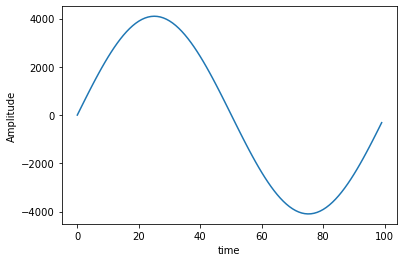

In [2]:
###      Mathematics of Music in Python      ###

import numpy as np

samplerate = 44100 #Frequecy in Hz

def get_wave(freq, duration=0.5):
    '''
    Function takes the "frequecy" and "time_duration" for a wave 
    as the input and returns a "numpy array" of values at all points 
    in time
    '''
    
    amplitude = 4096
    t = np.linspace(0, duration, int(samplerate * duration))
    wave = amplitude * np.sin(2 * np.pi * freq * t)
    
    return wave

# To get a 1 second long wave of frequency 440Hz
a_wave = get_wave(440, 1)

#wave features
print(len(a_wave)) # 44100
print(np.max(a_wave)) # 4096
print(np.min(a_wave)) # -4096

import matplotlib.pyplot as plt
plt.plot(a_wave[0:int(44100/440)])
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.show()

In [43]:
from pprint import pprint

def get_piano_notes():
    '''
    Returns a dict object for all the piano 
    note's frequencies
    '''
    # White keys are in Uppercase and black keys (sharps) are in lowercase
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B'] 
    base_freq = 261.63 #Frequency of Note C4
    
    note_freqs = {octave[i]: base_freq * pow(2,(i/12)) for i in range(len(octave))}        
    note_freqs[''] = 0.0 # silent note
    
    return note_freqs
  
# To get the piano note's frequencies
note_freqs = get_piano_notes() #### TRY INPUTING note_freqs AS A PULSE INPUT
pprint(note_freqs)
'''
        {'': 0.0,
        'A': 440.00745824565865,
        'B': 493.8916728538229,
        'C': 261.63,
        'D': 293.66974569918125,
        'E': 329.63314428399565,
        'F': 349.2341510465061,
        'G': 392.0020805232462,
        'a': 466.1716632541139,
        'c': 277.18732937722245,
        'd': 311.1322574981619,
        'f': 370.00069432367286,
        'g': 415.31173722644}
'''

{'': 0.0,
 'A': 440.00745824565865,
 'B': 493.89167285382297,
 'C': 261.63,
 'D': 293.66974569918125,
 'E': 329.63314428399565,
 'F': 349.2341510465061,
 'G': 392.0020805232462,
 'a': 466.1716632541139,
 'c': 277.18732937722245,
 'd': 311.1322574981619,
 'f': 370.00069432367286,
 'g': 415.31173722644}


"\n        {'': 0.0,\n        'A': 440.00745824565865,\n        'B': 493.8916728538229,\n        'C': 261.63,\n        'D': 293.66974569918125,\n        'E': 329.63314428399565,\n        'F': 349.2341510465061,\n        'G': 392.0020805232462,\n        'a': 466.1716632541139,\n        'c': 277.18732937722245,\n        'd': 311.1322574981619,\n        'f': 370.00069432367286,\n        'g': 415.31173722644}\n"

In [44]:
import numpy as np

def get_song_data(music_notes):
    '''
    Function to concatenate all the waves (notes)
    '''
    note_freqs = get_piano_notes() # Function that we made earlier
    song = [get_wave(note_freqs[note]) for note in music_notes.split('-')]
    song = np.concatenate(song)
    return song

music_notes = 'C-C-G-G-A-A-G--F-F-E-E-D-D-C--G-G-F-F-E-E-D--G-G-F-F-E-E-D--C-C-G-G-A-A-G--F-F-E-E-D-D-C'
data = get_song_data(music_notes)

data = data * (16300/np.max(data)) # Adjusting the Amplitude (Optional)

In [45]:
from scipy.io.wavfile import write
write('twinkle-twinkle.wav', samplerate, data.astype(np.int16))

In [46]:
                                ###     QISKIT PULSE      ###  
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
    
backend_defaults = backend.defaults()

ibmqfactory.load_account:WARNING:2021-04-10 10:24:18,243: Credentials are already in use. The existing account in the session will be replaced.


Sampling time: 0.2222222222222222 ns


In [47]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.971855969373953 GHz.
The sweep will go from 4.951855969373953 GHz to 4.991855969373953 GHz in steps of 1.0 MHz.


In [48]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

# Note	Frequency (Hz)	Wavelength (cm)
# A4	440.00	78.41

In [49]:
### Now attempt to take the frequencies created above, and use them as inputs for Qiskit Pulse.
### The Goal:
#       - To use note frequencies to rotate the Qubit (in Hz converted to pulse frequenciy Hz)
#       - And then to see if there's any correlation between Music and Quantum (Music Note Gaussians, etc).

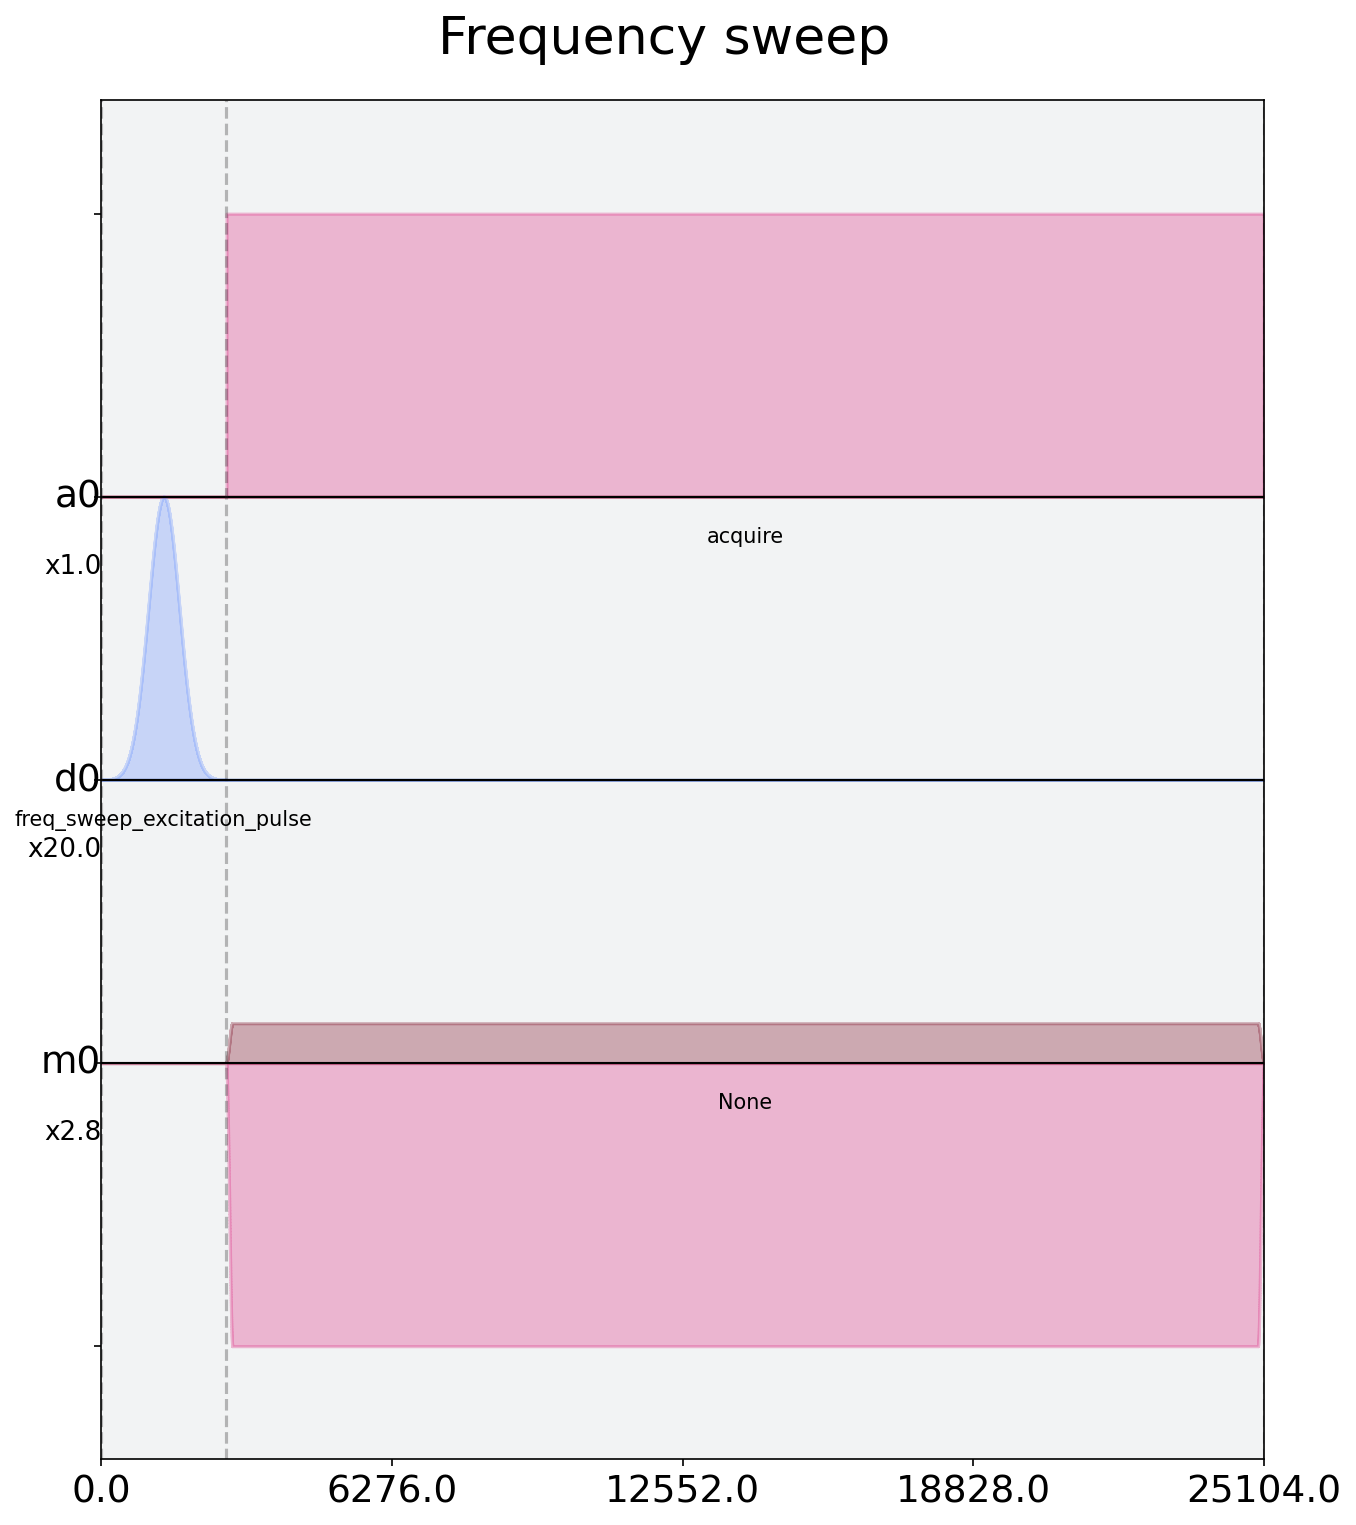

In [52]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz ######################## or 'data'
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

schedule.draw(label=True)

In [51]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [53]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

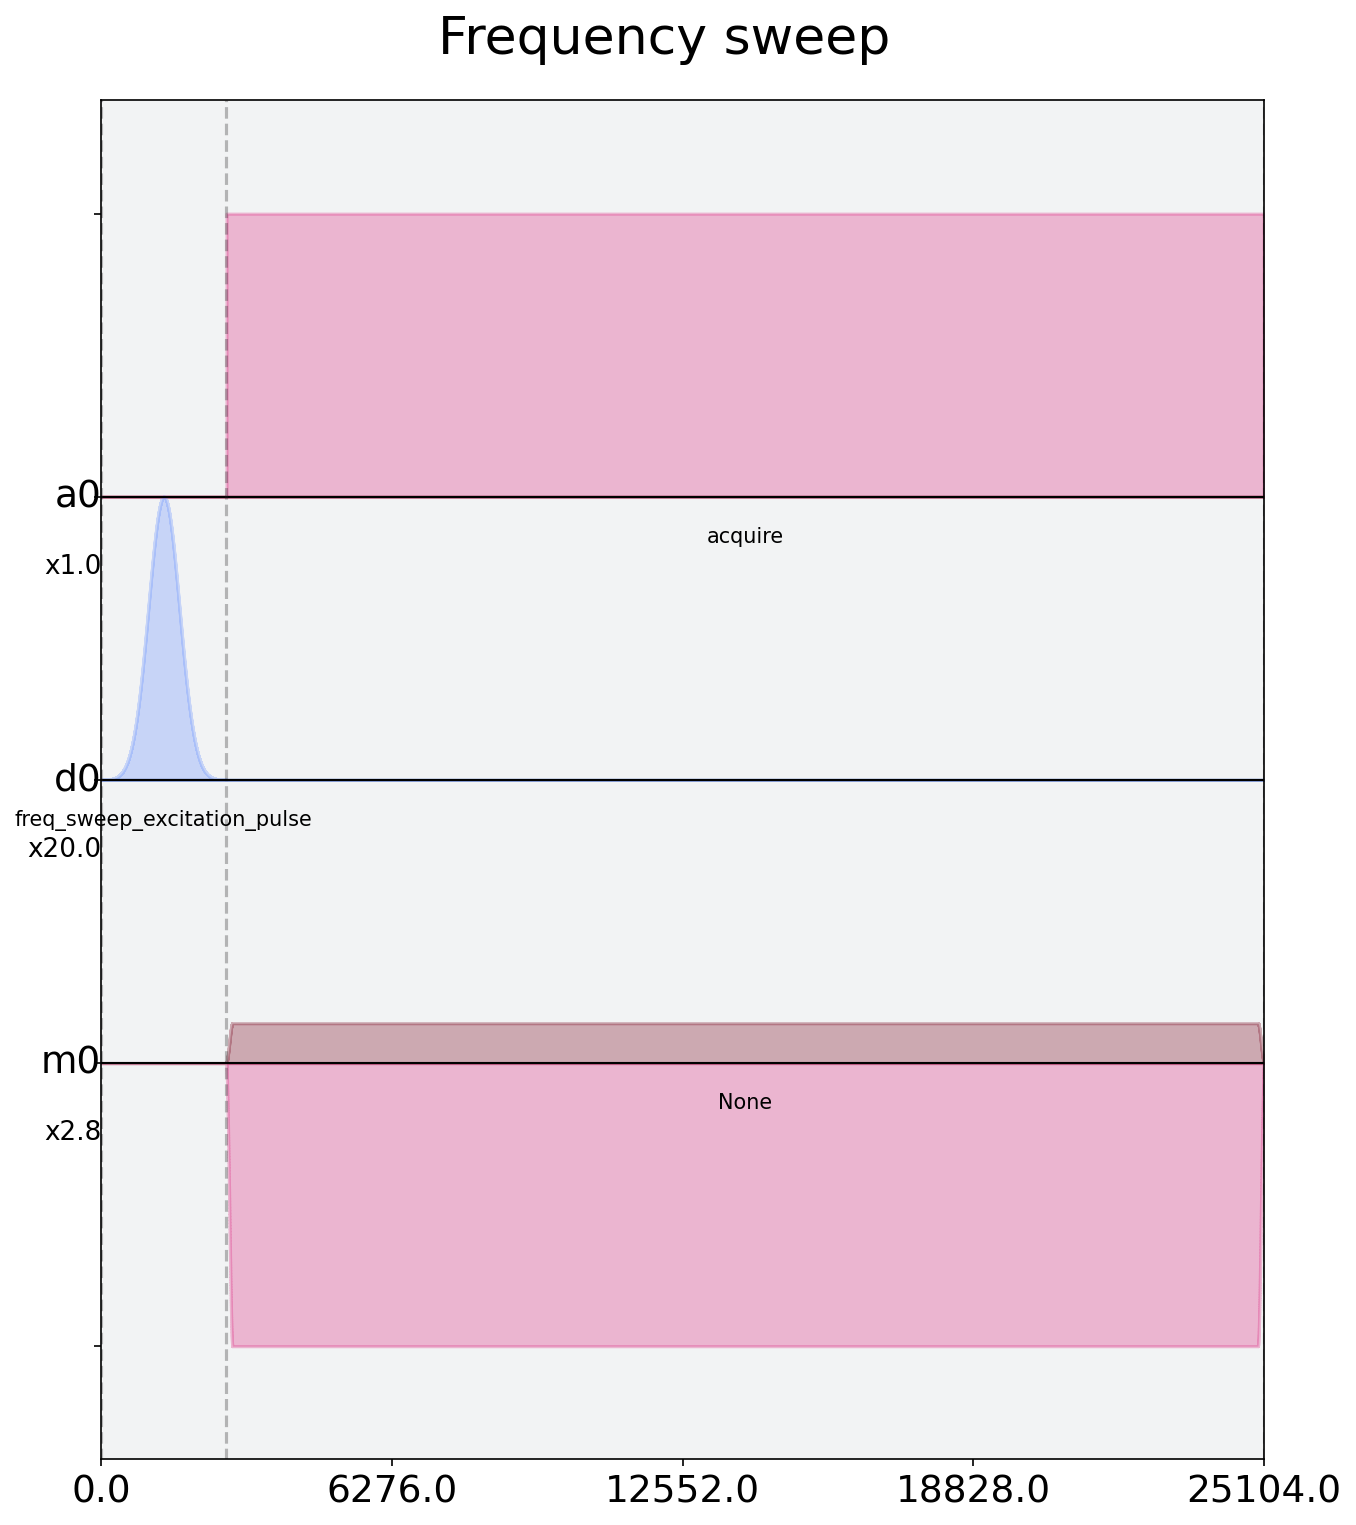

In [54]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

schedule.draw(label=True)

C:\Users\nexxu\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  # This is added back by InteractiveShellApp.init_path()


Job Status: job has successfully run


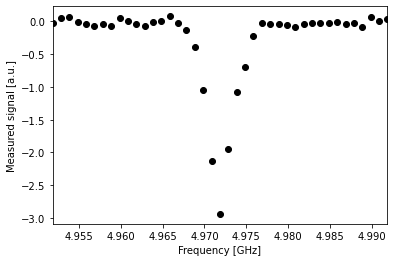

In [56]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)

# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

C:\Users\nexxu\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).


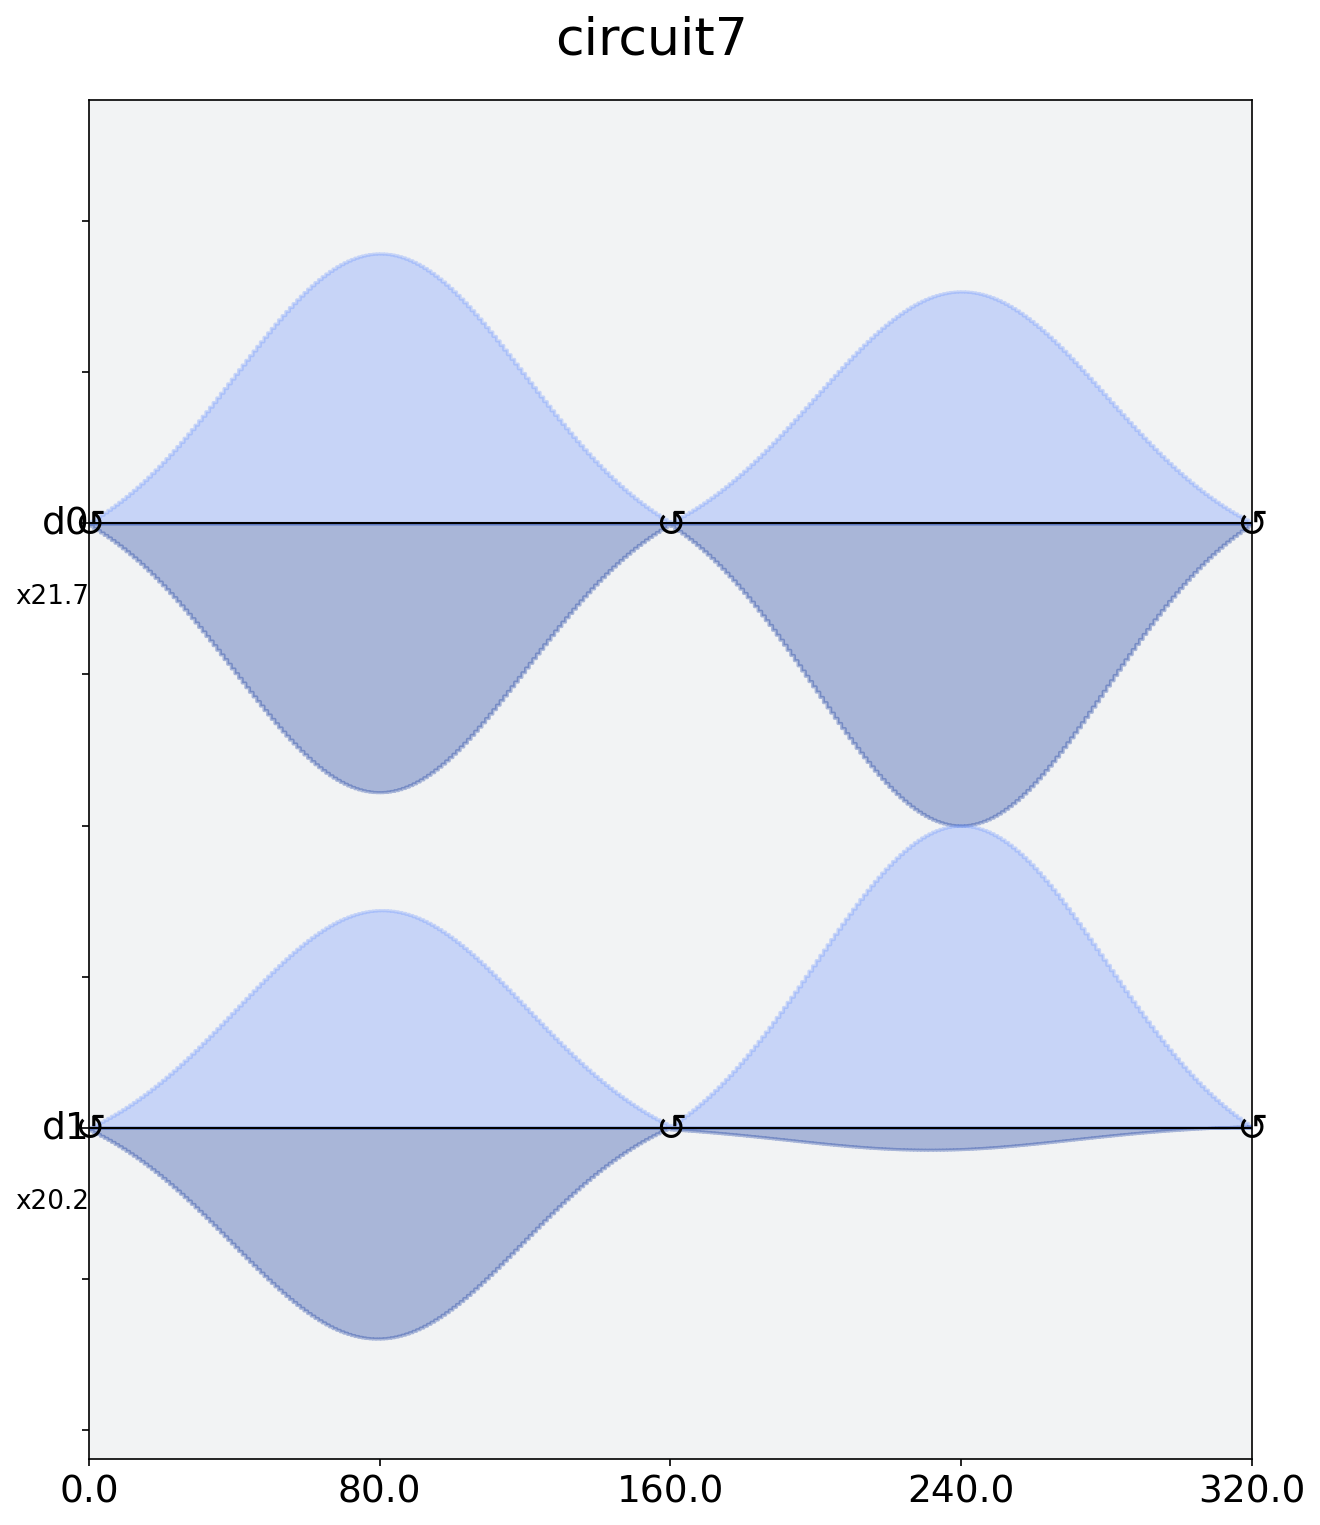

In [59]:
### Potential Sources:
## Music and Piecewise Gaussian Models: http://desolneux.perso.math.cnrs.fr/MVA/Cours-Gaussian-Music.pdf
## https://arxiv.org/pdf/1606.01039.pdf

from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit import transpile, schedule as build_schedule
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from math import pi

### Testing a general idea/concept. Now that it's working it should be ood to try passng in frequencies?
qcirc = QuantumCircuit(3, 3)
qcirc.u3(330,pi/4,pi/4,0) ## Theta angle is Note E Frequency in Hz
qcirc.u3(392,pi/4,pi/4,1) ## Theta angle is Note G Frequency in Hz
qcirc.measure([0, 1], [0, 1])

schedule = build_schedule(qcirc, backend,
                          method="as_late_as_possible")
schedule.draw(channels=[pulse.DriveChannel(0), pulse.DriveChannel(1)])

In [ ]:
### Referecing: https://towardsdatascience.com/mathematics-of-music-in-python-b7d838c84f72
#               "Qiskit Documentation for Qiskit Pulse"